In [11]:
#imports

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# gloabl params for all matplotlib plots
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
os.listdir('../DataSet/nasdaq/')

['finance.txt']

In [2]:
data_path = '../DataSet/'

In [3]:
df = pd.read_csv(data_path + 'nasdaq/finance.txt')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1991-01-02,373.000000,373.500000,371.799988,372.200012,372.200012,92020000
1,1991-01-03,371.200012,371.799988,367.399994,367.500000,367.500000,108390000
2,1991-01-04,366.500000,367.899994,365.899994,367.200012,367.200012,103830000
3,1991-01-07,363.500000,365.799988,360.100006,360.200012,360.200012,109460000
4,1991-01-08,359.100006,360.500000,358.200012,359.000000,359.000000,111730000


In [4]:
close_df = df['Close']
close_df.index = df['Date']
close_df.head()

Date
1991-01-02    372.200012
1991-01-03    367.500000
1991-01-04    367.200012
1991-01-07    360.200012
1991-01-08    359.000000
Name: Close, dtype: float64

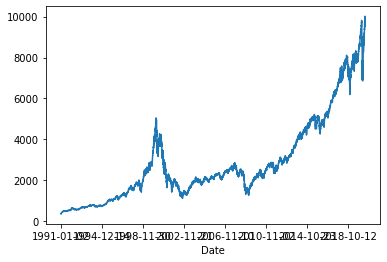

In [5]:
close_df.plot()

In [7]:
uni_data = close_df.values # numpy ndarray from pandas

In [13]:
TRAIN_SPLIT = (int)(0.7 * len(uni_data))

In [14]:
tf.random.set_seed(13) # random seed 

# Normalize data: mean centering and variance-scaling.
# NOTE: use only train data to normalize all of the data. otherwise, leakage-issue 
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std
print(type(uni_data))

<class 'numpy.ndarray'>


In [18]:
len(uni_data)

7424

In [19]:
# This function creates the data we need for the above problem
# dataset: numpy ndarray
# start_index:
# end_index:
# history_size: k => take k values at a time
# target_size: 0 => next value in the time-series
# Output: data: (n,k) and labels (n,1)

def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)


# use the above function to create the datasets.
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print(x_train_uni.shape)
print(y_train_uni.shape)
print(x_val_uni.shape)
print(y_val_uni.shape)

(5176, 20, 1)
(5176,)
(2208, 20, 1)
(2208,)


In [20]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.66518892]
 [-1.67076946]
 [-1.67112565]
 [-1.67943707]
 [-1.68086189]
 [-1.68264291]
 [-1.6774186 ]
 [-1.67753734]
 [-1.68466141]
 [-1.68288039]
 [-1.67350034]
 [-1.66091451]
 [-1.65948968]
 [-1.65628384]
 [-1.65711499]
 [-1.65129701]
 [-1.64251066]
 [-1.63894863]
 [-1.63598026]
 [-1.63146833]]

 Target temperature to predict
-1.6220883122289549


In [22]:
#utility function
def create_time_steps(length):
    return list(range(-length, 0))

print(create_time_steps(20))

[-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


<module 'matplotlib.pyplot' from 'C:\\Users\\91701\\anaconda3\\envs\\deep_learning1\\lib\\site-packages\\matplotlib\\pyplot.py'>

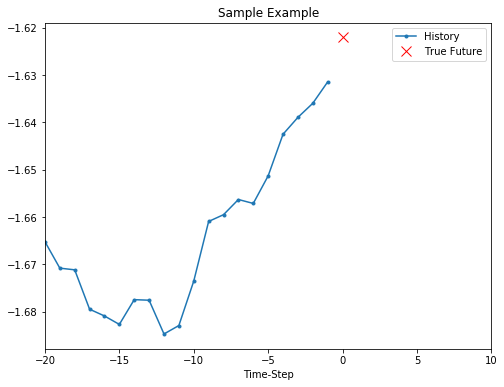

In [26]:
# Plotting function

# plot_data: contains labels as list
# delta: 0 => next time step given last "k" steps.
# title: plot title

# Usage: show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go'] # dot-line, red-x, green-o  refer: https://matplotlib.org/3.1.1/api/markers_api.html
  time_steps = create_time_steps(plot_data[0].shape[0])
  
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt


show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [23]:
# TF Dataset preperation
BATCH_SIZE = 256 # bacth size in batch-SGD/variants
BUFFER_SIZE = 10000 # for shuffling the dataset

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

print(train_univariate)
print(val_univariate)

<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>


In [24]:
# MODEL:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [25]:
# Train and evaluate
STEPS_PER_EPOCH = 200
EPOCHS = 10

# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 18ms/step - loss: 0.3258 - val_loss: 3.1048
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0731 - val_loss: 2.2329
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0491 - val_loss: 1.6544
Epoch 4/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0433 - val_loss: 1.4820
Epoch 5/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0394 - val_loss: 1.3490
Epoch 6/10
200/200 [==============================] - 4s 19ms/step - loss: 0.0364 - val_loss: 1.2356
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0344 - val_loss: 1.1665
Epoch 8/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0328 - val_loss: 1.1102
Epoch 9/10
200/200 [==============================] - 4s 20ms/step - loss: 0.0315 - val_loss: 1.0718
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0302 - val_lo

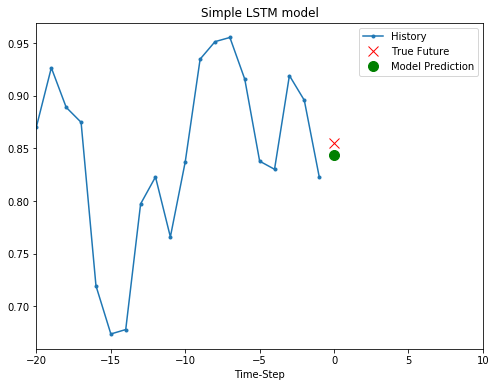

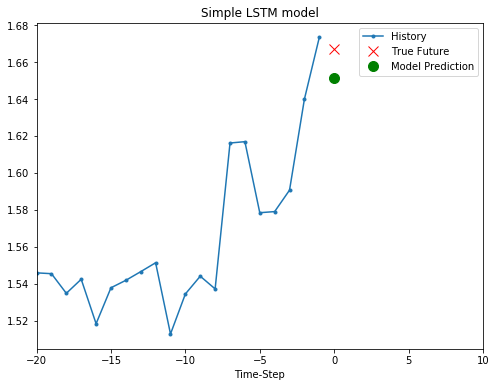

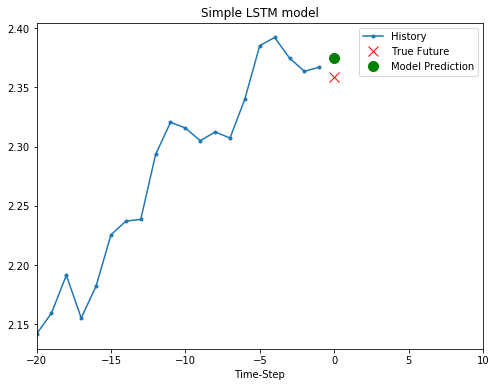

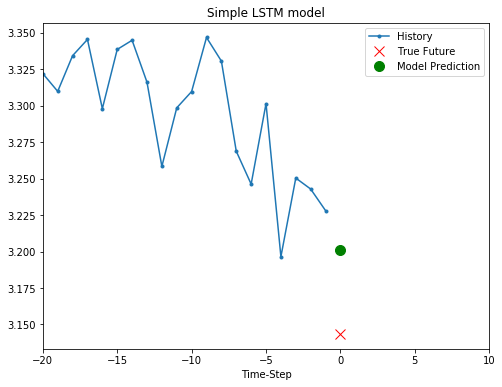

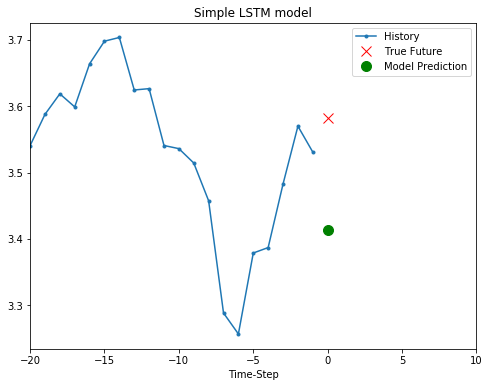

In [27]:
for x, y in val_univariate.take(5): # take 5 random inputs from validation data
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()